**Problem statement:**
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

Actinic keratosis

Basal cell carcinoma

Dermatofibroma

Melanoma

Nevus

Pigmented benign keratosis

Seborrheic keratosis

Squamous cell carcinoma

Vascular lesion



### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/data/melanoma/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/data/melanoma/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4733 files belonging to 9 classes.
Using 3787 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4733 files belonging to 9 classes.
Using 946 files for validation.


In [8]:
# also write down test data set here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

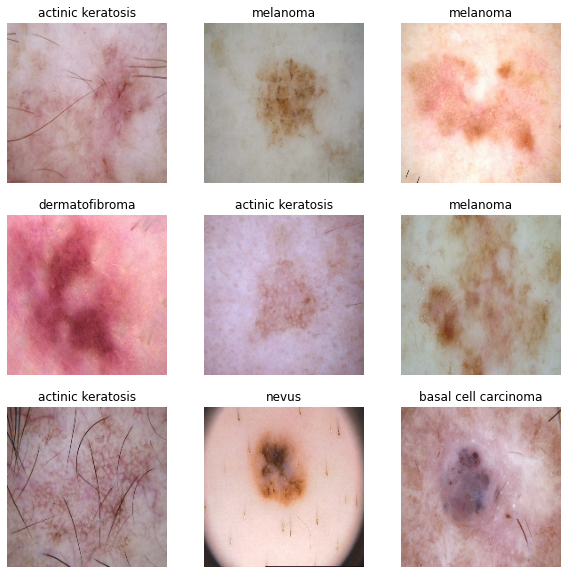

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]


In [13]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
119/119 [==============================] - 1107s 2s/step - loss: -260712.6875 - accuracy: 0.1883 - val_loss: -472823.4688 - val_accuracy: 0.1649
Epoch 2/20
119/119 [==============================] - 8s 65ms/step - loss: -3598176.5000 - accuracy: 0.1899 - val_loss: -5789985.0000 - val_accuracy: 0.1649
Epoch 3/20
119/119 [==============================] - 8s 66ms/step - loss: -14337940.0000 - accuracy: 0.1901 - val_loss: -25396680.0000 - val_accuracy: 0.1649
Epoch 4/20
119/119 [==============================] - 8s 67ms/step - loss: -37730600.0000 - accuracy: 0.1901 - val_loss: -102045968.0000 - val_accuracy: 0.1649
Epoch 5/20
119/119 [==============================] - 8s 65ms/step - loss: -76797568.0000 - accuracy: 0.1901 - val_loss: -122431088.0000 - val_accuracy: 0.1649
Epoch 6/20
119/119 [==============================] - 8s 65ms/step - loss: -134587392.0000 - accuracy: 0.1901 - val_loss: -179360112.0000 - val_accuracy: 0.1649
Epoch 7/20
119/119 [===========================

### Visualizing training results

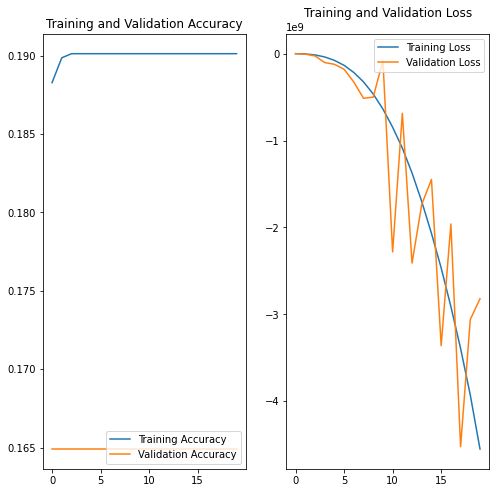

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


30/30 [==============================] - 1s 17ms/step - loss: -2821368320.0000 - accuracy: 0.1649
Accuracy:  0.19012410938739777
Validation Accuracy:  0.1649048626422882
Loss:  -2694371584.0
Validation Loss -2821368320.0


In [38]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


In [58]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: ignored

<Figure size 720x720 with 0 Axes>

### Todo:
### Create the model, compile and train the model


In [51]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_88 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_89 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_90 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_91 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

### Compiling the model

In [55]:
## Your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [56]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

In [57]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
                    epochs= epochs, verbose= 1, validation_data= valid_batches, callbacks=[learning_rate_reduction])
                    
  

Epoch 1/20
38/38 [==============================] - 82s 2s/step - loss: 1.4925 - accuracy: 0.3791 - val_loss: 1.2229 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 75s 2s/step - loss: 0.8725 - accuracy: 0.5732 - val_loss: 0.9531 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 75s 2s/step - loss: 0.7876 - accuracy: 0.6272 - val_loss: 1.2599 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 78s 2s/step - loss: 0.7128 - accuracy: 0.6849 - val_loss: 1.4044 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 78s 2s/step - loss: 0.6832 - accuracy: 0.6958 - val_loss: 1.4269 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 6/20
38/38 [==============================] - 77s 2s/step - loss: 0.6648 - accuracy: 0.7155 - val_loss: 1.0747 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 7/20
38/38 [==============================] - 75s 2s/step - loss: 0.6495 - a

### Visualizing the results

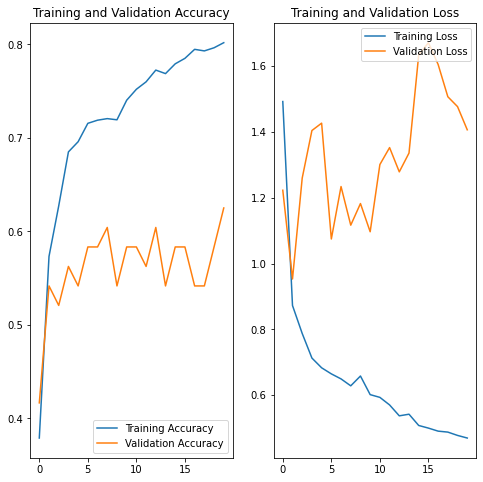

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
loss, accuracy= model.evaluate(train_batches, verbose=1,)
loss_v, accuracy_v = model.evaluate(valid_batches, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


1/1 [==============================] - 5s 5s/step - loss: 1.4858 - accuracy: 0.6042
Accuracy:  0.8108786344528198
Validation Accuracy:  0.6041666865348816
Loss:  0.46708786487579346
Validation Loss 1.4857665300369263


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

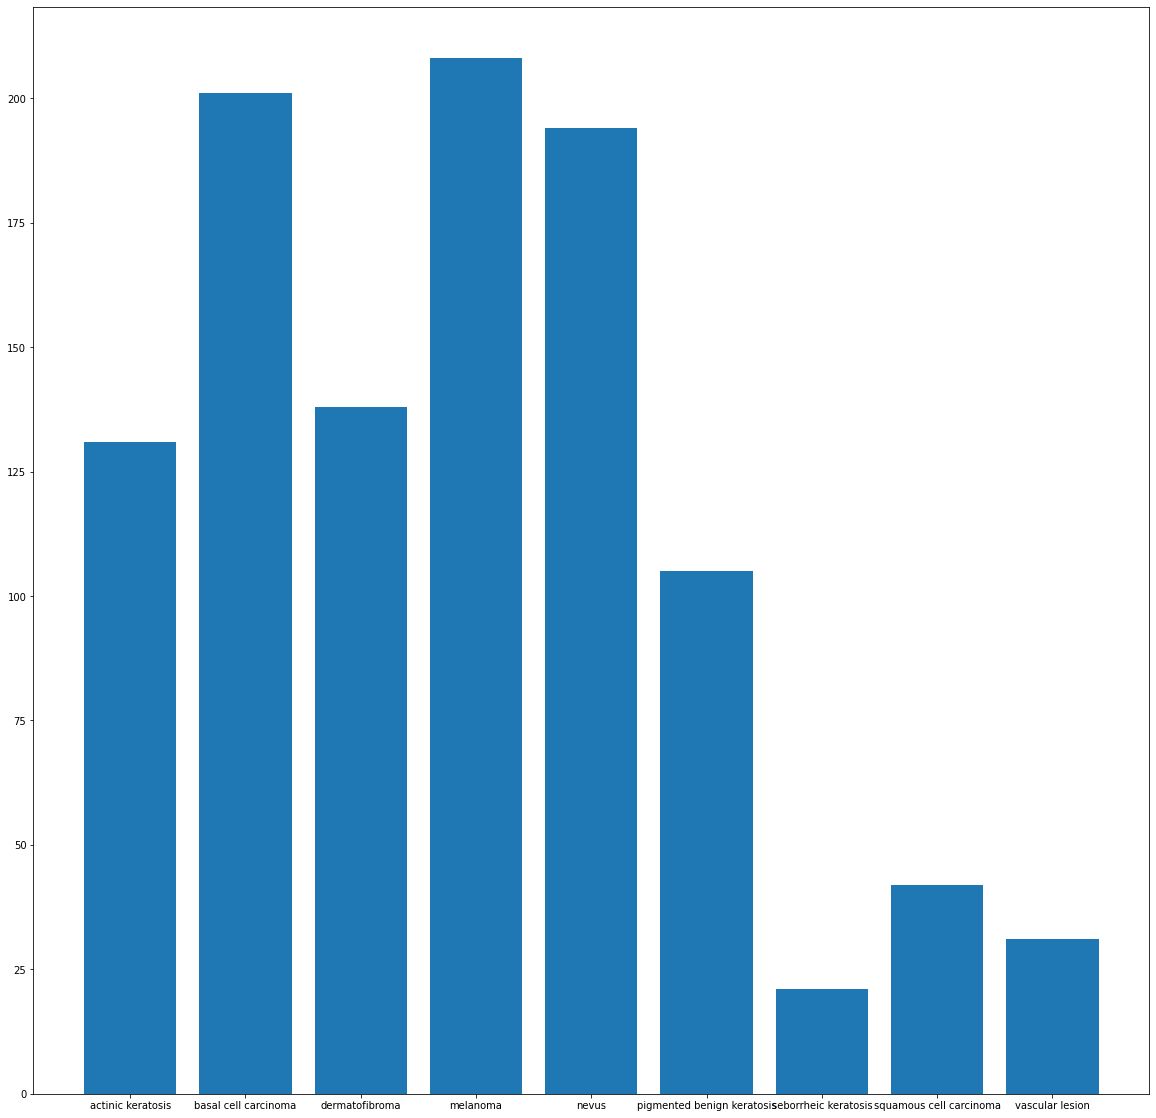

In [62]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
### ans- keratosis squamous
#### - Which classes dominate the data in terms proportionate number of samples?
### ans- pigmented benign keratosis- domintes the data of count more than 95 in training


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [63]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [64]:
path_to_training_dataset= "/content/gdrive/MyDrive/data/melanoma/Train"
import Augmentor
import os
for i in class_names:
  dir = os.path.join(path_to_training_dataset , i)
  print(dir)
  p = Augmentor.Pipeline(dir)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2963E5BB0>: 100%|██████████| 500/500 [00:27<00:00, 18.12 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF2784A5C40>: 100%|██████████| 500/500 [00:21<00:00, 23.65 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2784B7C40>: 100%|██████████| 500/500 [00:22<00:00, 22.44 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF2784A3A30>: 100%|██████████| 500/500 [01:55<00:00,  4.33 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x634 at 0x7FF2784095E0>: 100%|██████████| 500/500 [01:41<00:00,  4.95 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF2962D42B0>: 100%|██████████| 500/500 [00:22<00:00, 22.29 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF2966F0F10>: 100%|██████████| 500/500 [00:47<00:00, 10.47 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF29602C8B0>: 100%|██████████| 500/500 [00:20<00:00, 23.91 Samples/s]


/content/gdrive/MyDrive/data/melanoma/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/data/melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF27B2F3CA0>: 100%|██████████| 500/500 [00:21<00:00, 22.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [65]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6994


### Lets see the distribution of augmented data after adding new images to the original training data.

In [71]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_d0c0e1c8-532d-4726-920a-2cbca08f9342.jpg',
 '/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_d977b651-37bd-4fcd-83ce-804b168103ee.jpg',
 '/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_8c527148-d08f-470f-83d8-e05950c3b38a.jpg',
 '/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_525122d9-d13a-46c1-9b41-72d2e633f1e0.jpg',
 '/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_62611614-077d-4917-9295-de8d32247ad4.jpg',
 '/content/gdrive/MyDrive/data/melanoma/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_bd318070-b65e-406d-84e0-72cba509f768.jpg',
 '/content/gdrive/MyDrive/data/melanoma/Train/actini

In [72]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [73]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [74]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [75]:
new_df['Label'].value_counts()

basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
actinic keratosis              994
pigmented benign keratosis     500
seborrheic keratosis           500
squamous cell carcinoma        500
vascular lesion                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [76]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [79]:
data_dir_train="/content/gdrive/MyDrive/data/melanoma/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9233 files belonging to 9 classes.
Using 7387 files for training.


#### **Todo:** Create a validation dataset

In [81]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9233 files belonging to 9 classes.
Using 1846 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [82]:
## your code goes here
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_103 (ModuleW  (None, 180, 180, 32)     896       
 rapper)                                                         
                                                                 
 module_wrapper_104 (ModuleW  (None, 180, 180, 32)     9248      
 rapper)                                                         
                                                                 
 module_wrapper_105 (ModuleW  (None, 90, 90, 32)       0         
 rapper)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [83]:
## your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [84]:
epochs = 30
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
231/231 [==============================] - 57s 234ms/step - loss: 0.0000e+00 - accuracy: 0.1459 - val_loss: 0.0000e+00 - val_accuracy: 0.1614 - lr: 0.0010
Epoch 2/30
231/231 [==============================] - 84s 359ms/step - loss: 0.0000e+00 - accuracy: 0.1459 - val_loss: 0.0000e+00 - val_accuracy: 0.1614 - lr: 0.0010
Epoch 3/30
231/231 [==============================] - 52s 222ms/step - loss: 0.0000e+00 - accuracy: 0.1459 - val_loss: 0.0000e+00 - val_accuracy: 0.1614 - lr: 0.0010
Epoch 4/30
231/231 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1459
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
231/231 [==============================] - 51s 215ms/step - loss: 0.0000e+00 - accuracy: 0.1459 - val_loss: 0.0000e+00 - val_accuracy: 0.1614 - lr: 0.0010
Epoch 5/30
231/231 [==============================] - 51s 218ms/step - loss: 0.0000e+00 - accuracy: 0.1459 - val_loss: 0.0000e+00 - val_accuracy: 0.1614 - lr: 5.0000e-04
E

#### **Todo:**  Visualize the model results

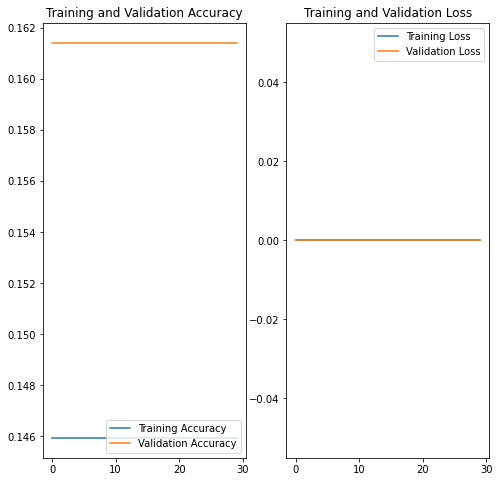

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [91]:
#The class rebalance helped in reducing overfititng of the data and thus the loss is reduced But it reduced the Acurracy very low

#Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

#Then we introduced dropout and ImageDataGenerator which reduced the over fit

#At last we tried Batch Normalization and Augumentation which really helped in carry forward